In [ ]:
#Kelvin Encarnacao: webmd drug networks code

In [2]:
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import re
import Levenshtein
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords

In [3]:
webmd = pd.read_csv('webmd.csv')

In [4]:
stopwords = set(stopwords.words('english'))

In [132]:
#preprocessing, lowercase set, removing stopwords from reviews, setting all values to strings other than ratings
for colName in ['Drug','Condition','Reviews','Sides','Sex']:
    webmd[colName] = webmd[colName].str.lower()
    if colName == 'Reviews':
        webmd[colName]=webmd[colName].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stopwords)]))

#remove stopwords from all reviews
#for review in webmd.Reviews
#merge duplicate drugs with same Ids but different string names, some duplicate row issues under different name
for drugId in set(webmd['DrugId'].tolist()):
    drugs = set(webmd[webmd['DrugId']==drugId]['Drug'].tolist())
    if len(drugs)>1:#more than one drug under same id
        merge = min(drugs, key=len)
        webmd.loc[webmd['DrugId']==drugId, 'Drug'] = merge

webmd = webmd[webmd['Satisfaction']<=5]

webmd = webmd.drop_duplicates()
webmd.Reviews = webmd.Reviews.fillna('')

In [133]:
def preprocess(text): 
    # get lowercase
    text = text.lower()
    # remove numbers  
    text = re.sub(r'\d+', '', text)
    # remove urls
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    # remove punctuation
    text = text.translate(text.maketrans('', '', string.punctuation))
    # strip whitespace
    text = text.strip()
    # remove stop words
    #stemmer= PorterStemmer()
    #tokens = word_tokenize(text)
    #words = [stemmer.stem(w) for w in tokens]
    return text

In [45]:
webmd.head()

Age      Condition       Date                          Drug  DrugId  \
0  75 or over    stuffy nose  9/21/2014                  25dph-7.5peh  146724   
1       25-34  cold symptoms  1/13/2011                  25dph-7.5peh  146724   
2       65-74          other  7/16/2012  warfarin (bulk) 100 % powder  144731   
3  75 or over          other  9/23/2010  warfarin (bulk) 100 % powder  144731   
4       35-44          other   1/6/2009  warfarin (bulk) 100 % powder  144731   

   EaseofUse  Effectiveness  \
0          5              5   
1          5              5   
2          2              3   
3          2              2   
4          1              1   

                                             Reviews  Satisfaction     Sex  \
0  i'm retired physician meds tried allergies (se...             5    male   
1  cleared right even throat hurting went away ta...             5  female   
2                           ptinr go normal 2.5 100?             3  female   
3                                    falling realise             1  female   
4  grandfather prescribed medication (coumadin) a...             1    male   

                                               Sides  UsefulCount  
0  drowsiness,  dizziness ,  dry mouth /nose/thro...            0  
1  drowsiness,  dizziness ,  dry mouth /nose/thro...            1  
2                                                               0  
3                                                               0  
4                                                               1

In [134]:
#Set of unique conditions identified in reviews and drugs reviewed in dataset. 
conditions = set(webmd['Condition'].tolist())
drugs = set(webmd['Drug'].tolist())

In [13]:
len(drugs)

6572

In [14]:
len(conditions)

1806

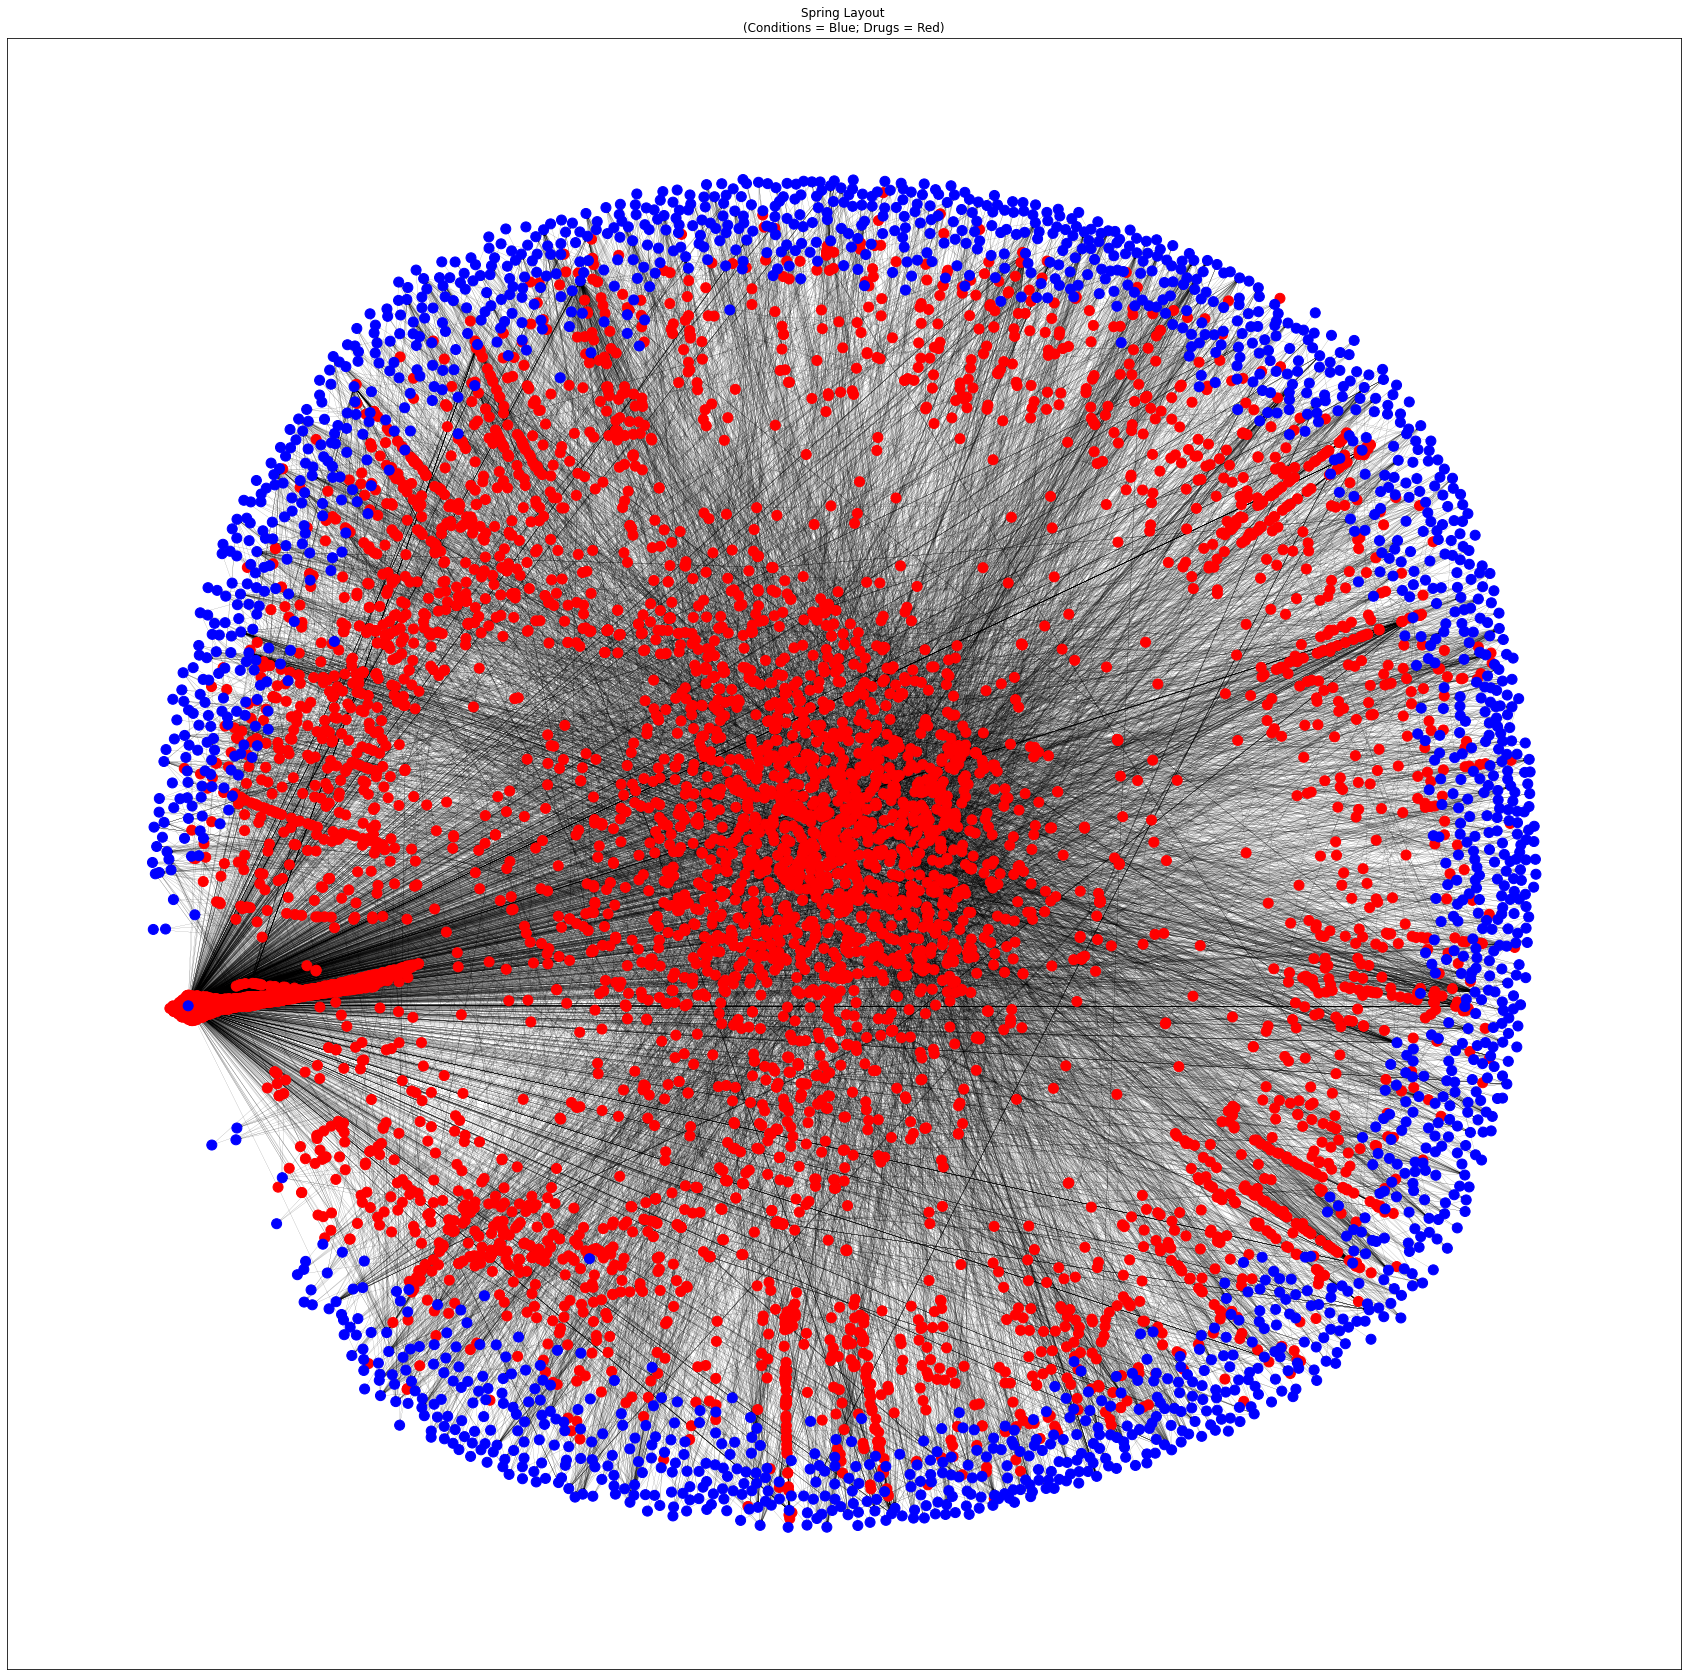

In [97]:
#Nodes to represent drugs in network
drugNodes = []
for drugName in drugs:
    node = (drugName, {'type':'drug'})
    drugNodes += [node]
#Nodes to represent conditions in network
conditionNodes = []
for conditionName in conditions:
    node = (conditionName, {'type':'condition'})
    conditionNodes += [node]
    
nodes = drugNodes + conditionNodes

#Create edge list that connects drugs with conditions they are identified as used for in review
edgeList = []
for drug in drugs:
    rows = webmd[webmd['Drug'] == drug]
    condList = set(rows['Condition'].tolist())#TODO, take into account # of reviews for each condition for width
    for condition in condList:
        edge = (drug, condition)
        edgeList+= [edge]
        
#Creation of total graph with drug and condition nodes and edges connecting drugs with associated reviewed conditions
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edgeList)


node_type_color = ['r' if G.nodes[n]['type'] == 'drug' else 'b' for n in G.nodes]


plt.figure(figsize = (30, 30))
plt.title("Spring Layout \n(Conditions = Blue; Drugs = Red)", loc='center')
pos = nx.spring_layout(G) 
nx.draw_networkx(G, pos, node_color = node_type_color, with_labels = False, node_size = 100, arrowsize=1, width = .1 )
plt.show()

In [83]:
#Which drugs have been reviewed for the most differnet conditions
Counter(nx.out_degree_centrality(G)).most_common(20)

[('prednisone', 0.0109863864342011),
 ('cipro', 0.007045617387150704),
 ('methylprednisolone', 0.006209696680200621),
 ('ciprofloxacin', 0.005732027704800574),
 ('levaquin', 0.00549319321710055),
 ('kenalog-40 vial', 0.0051349414855505135),
 ('doxycycline hyclate tablet tetracyclines', 0.005015524241700502),
 ('azithromycin', 0.004776689754000478),
 ('metronidazole', 0.004657272510150466),
 ('levofloxacin', 0.004418438022450442),
 ('doxycycline calcium syrup', 0.00429902077860043),
 ('bactrim ds', 0.0040601862909004065),
 ('clarithromycin', 0.0040601862909004065),
 ('dexamethasone', 0.0040601862909004065),
 ('medrol tablet', 0.0040601862909004065),
 ('amoxicillin', 0.0040601862909004065),
 ('medrol', 0.0040601862909004065),
 ('flagyl', 0.0040601862909004065),
 ('clindamycin hcl', 0.0037019345593503703),
 ('prednisolone', 0.0037019345593503703)]

In [84]:
#Which conditions are identified as being reviewed for the most
Counter(nx.in_degree_centrality(G)).most_common(20)

[('other', 0.4856699307379986),
 ('osteoporosis', 0.025674707427752567),
 ('birth control', 0.02340577979460234),
 ('high blood pressure', 0.021733938380702172),
 ('acne', 0.021256269405302126),
 ('pain', 0.020778600429902077),
 ('painful periods', 0.016837831382851685),
 ('cough', 0.015763076188201577),
 ('cold symptoms', 0.014927155481251493),
 ('rheumatoid arthritis', 0.01468832099355147),
 ('type 2 diabetes mellitus', 0.013255314067351327),
 ('abnormally long or heavy periods', 0.013016479579651302),
 ('inflammation of the nose due to an allergy', 0.013016479579651302),
 ('incomplete or infrequent bowel movements', 0.012658227848101266),
 ('stuffy nose', 0.012419393360401243),
 ('disease of ovaries with cysts', 0.01170288989730117),
 ('allergic conjunctivitis', 0.011105803678051111),
 ('migraine headache', 0.00979221399570098),
 ('anemia from inadequate iron', 0.009672796751850968),
 ('endometriosis', 0.009075710532600909)]

In [97]:
#least associated conditions in network, conditions with lowest amount of associated drugs
list_indeg_conds = [i for i in Counter(nx.out_degree_centrality(G)).most_common() if i[0] in drugs]
sorted(list_indeg_conds,key=lambda x: x[1], reverse=False)[:200]

[('guanethidine powder', 0.00011941724385001195),
 ('fentanyl spray, non-aerosol', 0.00011941724385001195),
 ('aqu aerosol, spray with pump', 0.00011941724385001195),
 ('granix 480 mcg/0.8 ml subcutaneous syringe leukocyte stimulating factors',
  0.00011941724385001195),
 ('pyrithione zinc shampoo', 0.00011941724385001195),
 ('retavase kit', 0.00011941724385001195),
 ('glucagon (human recombinant) 1 mg solution for injection',
  0.00011941724385001195),
 ('tactinal tablet', 0.00011941724385001195),
 ('benadryl itch stopping cream', 0.00011941724385001195),
 ('piroxicam (bulk) 100 % powder', 0.00011941724385001195),
 ('silica gel powder', 0.00011941724385001195),
 ('dmsa (bulk) 98 % powder', 0.00011941724385001195),
 ('plo gel mediflo pre-mixed', 0.00011941724385001195),
 ('nighttime d cold-flu relief', 0.00011941724385001195),
 ('adult probiotic', 0.00011941724385001195),
 ('co q-10 capsule', 0.00011941724385001195),
 ('sodium nitrite granules', 0.00011941724385001195),
 ('penicillin g

In [42]:
#snapshot for amoxicillin in drug-condition network, better look at network capabilities and can see specifics in coloring
#and labels for conditions as well as edge width weighting. 
G3 = nx.DiGraph()
specificNodes = [('amoxicillin',{'type':'drug'})]
rowSpec = webmd[webmd['Drug']=='amoxicillin']
condListSpec = set(rowSpec['Condition'].tolist())
for condition in condListSpec:
    node = (condition, {'type':'condition'})
    conditionSatisfactionColor=0
    #condReviews = ''.join(rowSpec[rowSpec['Condition']==condition].Reviews.tolist())
    satisfactionByCondition = sum(rowSpec[rowSpec['Condition']==condition].Satisfaction.tolist())/len(rowSpec[rowSpec['Condition']==condition].Satisfaction.tolist())
    if satisfactionByCondition>=3.5:
        conditionSatisfactionColor='green'
    elif satisfactionByCondition>=2:
        conditionSatisfactionColor='yellow'
    else:
        conditionSatisfactionColor='red'
        
    if condition != 'other':#remove other because takes up majority of reviews and does not tell us anything without extra context
        specificNodes += [node]
        G3.add_edge('amoxicillin', condition,weight=len(rowSpec[rowSpec['Condition']==condition].Reviews.tolist()),color=conditionSatisfactionColor)
G3.add_nodes_from(specificNodes)
node_type_color_spec = ['r' if G3.nodes[n]['type'] == 'drug' else 'b' for n in G3.nodes]

#Full drug-drug assocaition network
plt.figure(figsize = (30, 30))
plt.title("Spring Layout \n(Drug - Drug relatoinships from reviews)", loc='center')
pos = nx.spring_layout(G3) 
nx.draw_networkx(G3, pos, with_labels = False, node_size = 100, arrowsize=1, width = .1 )
plt.show()


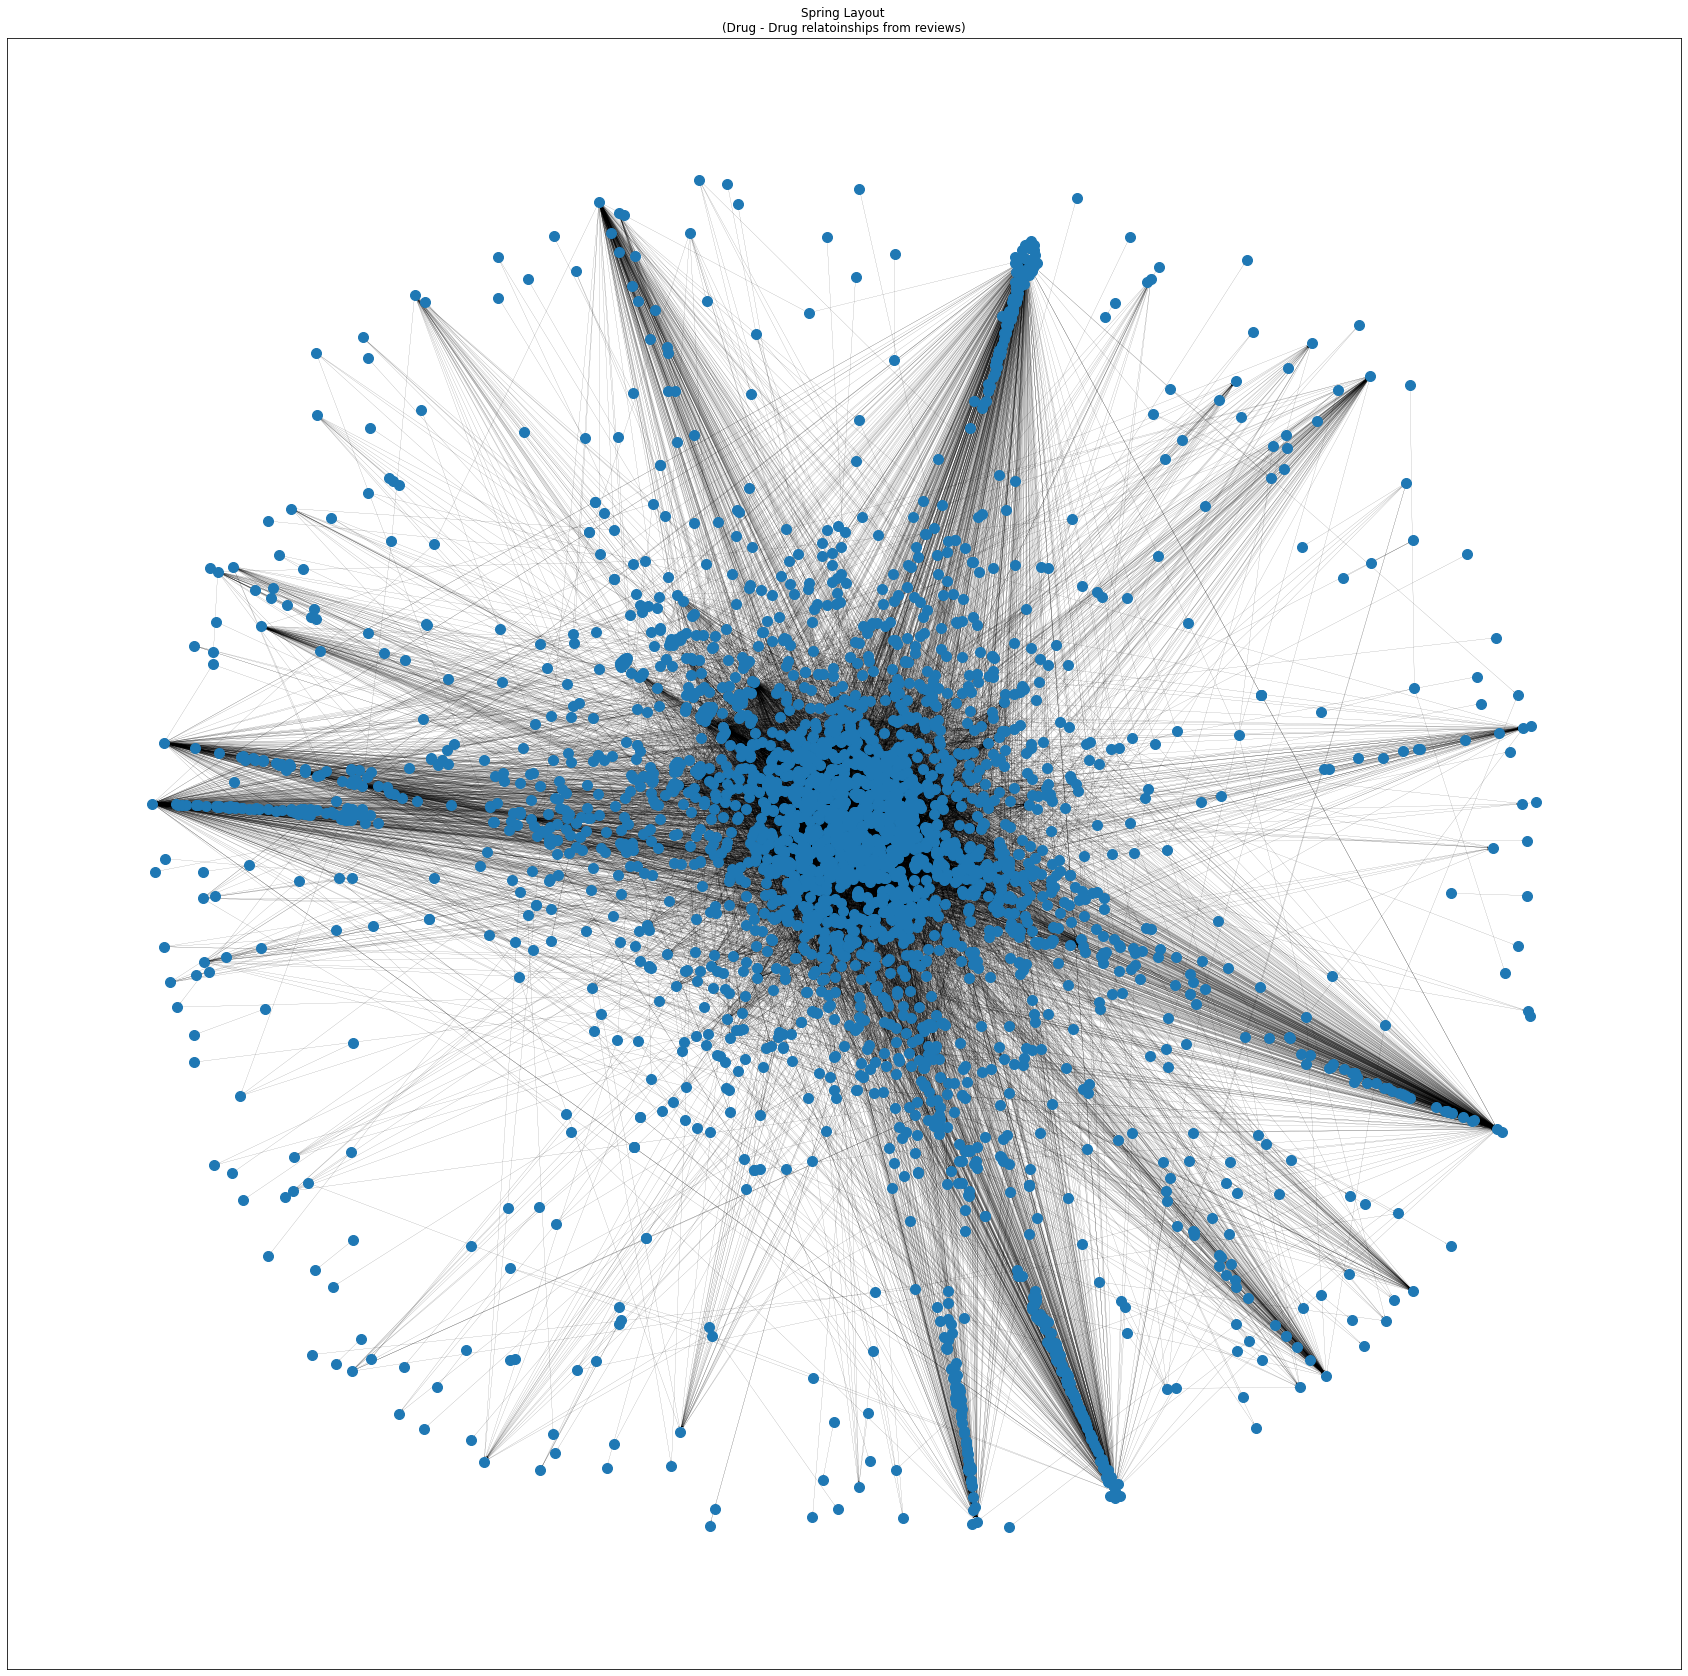

In [217]:
#Create different edgeList connecting drugs with other drugs if they are mentioned in a review of a drug.
edgeListDrugs = []
nodesListDrugs =[]
for drug in drugs:
    rows = webmd[webmd['Drug'] == drug]
    reviews = [str(i).translate(str.maketrans('','',string.punctuation)) for i in set(''.join(rows['Reviews'].tolist()).split())]
    #print(reviews)
    for drug2 in drugs:
        if drug2 in reviews and drug2 != drug:
            nodesListDrugs += [drug,drug2]
            edgeListDrugs+=[(drug, drug2)]
            
nodesListDrugs = set(nodesListDrugs)

G2 = nx.DiGraph()
G2.add_nodes_from(nodesListDrugs)
G2.add_edges_from(edgeListDrugs)

#Full drug-drug assocaition network
plt.figure(figsize = (30, 30))
plt.title("Spring Layout \n(Drug - Drug relatoinships from reviews)", loc='center')
pos = nx.spring_layout(G2) 
nx.draw_networkx(G2, pos, with_labels = False, node_size = 100, arrowsize=1, width = .1 )
plt.show()

In [155]:
#Drugs who have highest number of other drugs mentioned in their own reviews.
Counter(nx.out_degree_centrality(G2)).most_common(20)

[('cymbalta', 0.03433616742969261),
 ('lisinopril', 0.033355134074558535),
 ('topamax', 0.029758011772400263),
 ('prednisone', 0.029758011772400263),
 ('lyrica', 0.026487900588620016),
 ('neurontin', 0.024525833878351867),
 ('tramadol hcl', 0.02419882275997384),
 ('effexor xr', 0.023871811641595814),
 ('pristiq', 0.02289077828646174),
 ('seroquel', 0.02223675604970569),
 ('zoloft', 0.021909744931327666),
 ('hydrocodone-acetaminophen', 0.021909744931327666),
 ('lexapro', 0.02158273381294964),
 ('lamictal', 0.021255722694571617),
 ('gabapentin', 0.020928711576193592),
 ('adderall', 0.019620667102681493),
 ('phentermine hcl', 0.018966644865925444),
 ('celexa', 0.018312622629169394),
 ('wellbutrin xl', 0.018312622629169394),
 ('trazodone hcl', 0.01798561151079137)]

In [156]:
#Drugs who appear most in other reviews. (Some common drug names mess things up ex. D, preven, cough)
Counter(nx.in_degree_centrality(G2)).most_common(20)

[('prevent', 0.2298888162197515),
 ('cough', 0.19130150425114456),
 ('awake', 0.16906474820143885),
 ('allergy', 0.1527141922825376),
 ('tylenol', 0.12655330281229563),
 ('alli', 0.12524525833878353),
 ('d', 0.1249182472204055),
 ('prednisone', 0.10856769130150426),
 ('benadryl', 0.10595160235448006),
 ('ibuprofen', 0.10235448005232178),
 ('aspirin', 0.08371484630477437),
 ('advil', 0.08273381294964029),
 ('iron', 0.07782864617396992),
 ('calcium', 0.07717462393721387),
 ('cramp', 0.06344015696533682),
 ('vicodin', 0.06213211249182472),
 ('cymbalta', 0.055264879005886204),
 ('ambien', 0.053956834532374105),
 ('zoloft', 0.049705689993459784),
 ('valium', 0.048070634401569654)]

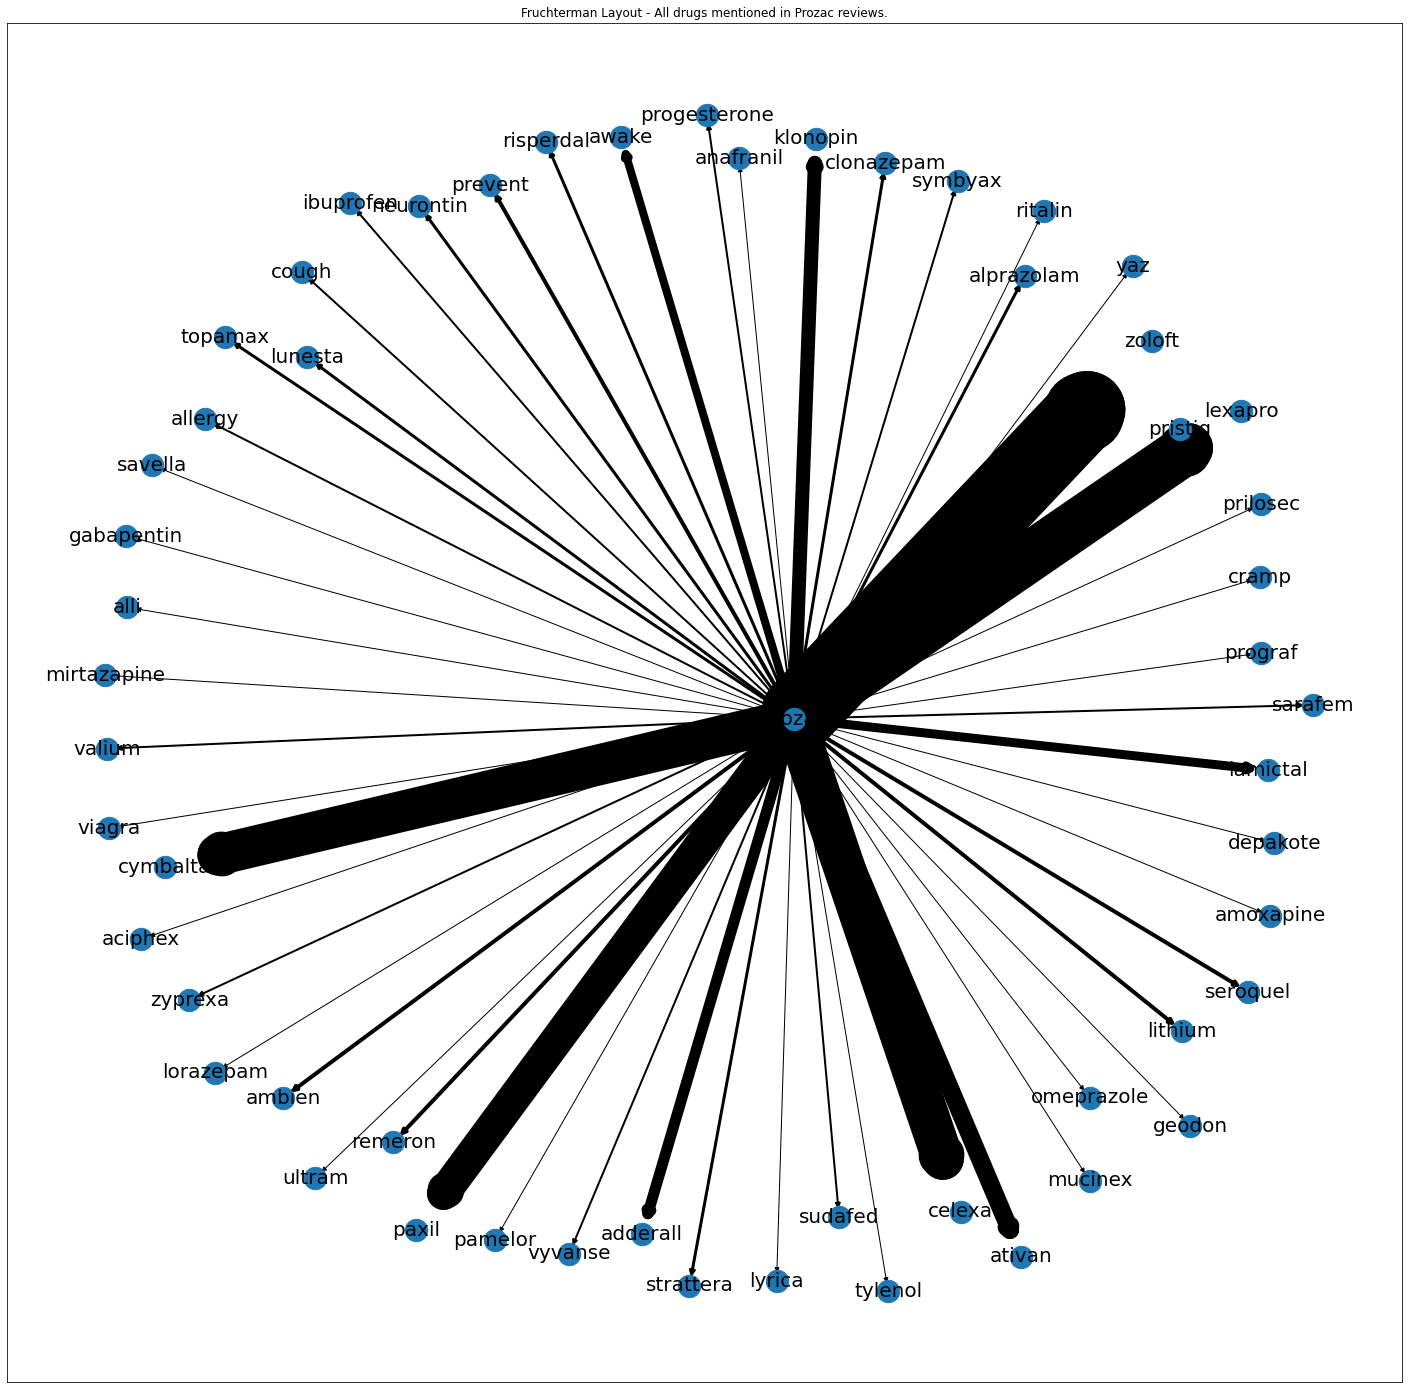

In [158]:
#snapshot for amoxicillin, better look at network capabilities and possible insights
G9 = nx.DiGraph()
edgeListDrugs2 = []
nodesListDrugs2 =[]
for drug in ['prozac']:
    rows = webmd[webmd['Drug'] == drug]
    reviews = [str(i).translate(str.maketrans('','',string.punctuation)) for i in ''.join(rows['Reviews'].tolist()).split()]
    #print(reviews)
    for drug2 in drugs:
        count = reviews.count(drug2)
        if count>0 and drug2 != drug:
            nodesListDrugs2 += [drug,drug2]
            G9.add_edge(drug, drug2,weight=count)
            edgeListDrugs2+=[(drug, drug2)]
            
nodesListDrugs2 = set(nodesListDrugs2)
G9.add_nodes_from(nodesListDrugs2)
#G3.add_weighted_edges_from(edgeListSpec)

#node_type_color_spec2 = ['r' if G4.nodes[n]['type'] == 'drug' else 'b' for n in G4.nodes]

plt.figure(figsize = (25, 25))
plt.title("Fruchterman Layout - All drugs mentioned in Prozac reviews.", loc='center')
pos = nx.fruchterman_reingold_layout(G9) 
#nx.draw_networkx(G3,pos, node_size = 1000, font_size = 15, node_color = node_type_color_spec)
nx.draw_networkx_nodes(G9,pos, node_size=500)
nx.draw_networkx_labels(G9,pos, font_size = 20)
for edge in G9.edges(data='weight'):
    nx.draw_networkx_edges(G9, pos, edgelist=[edge], width=edge[2])
plt.show()

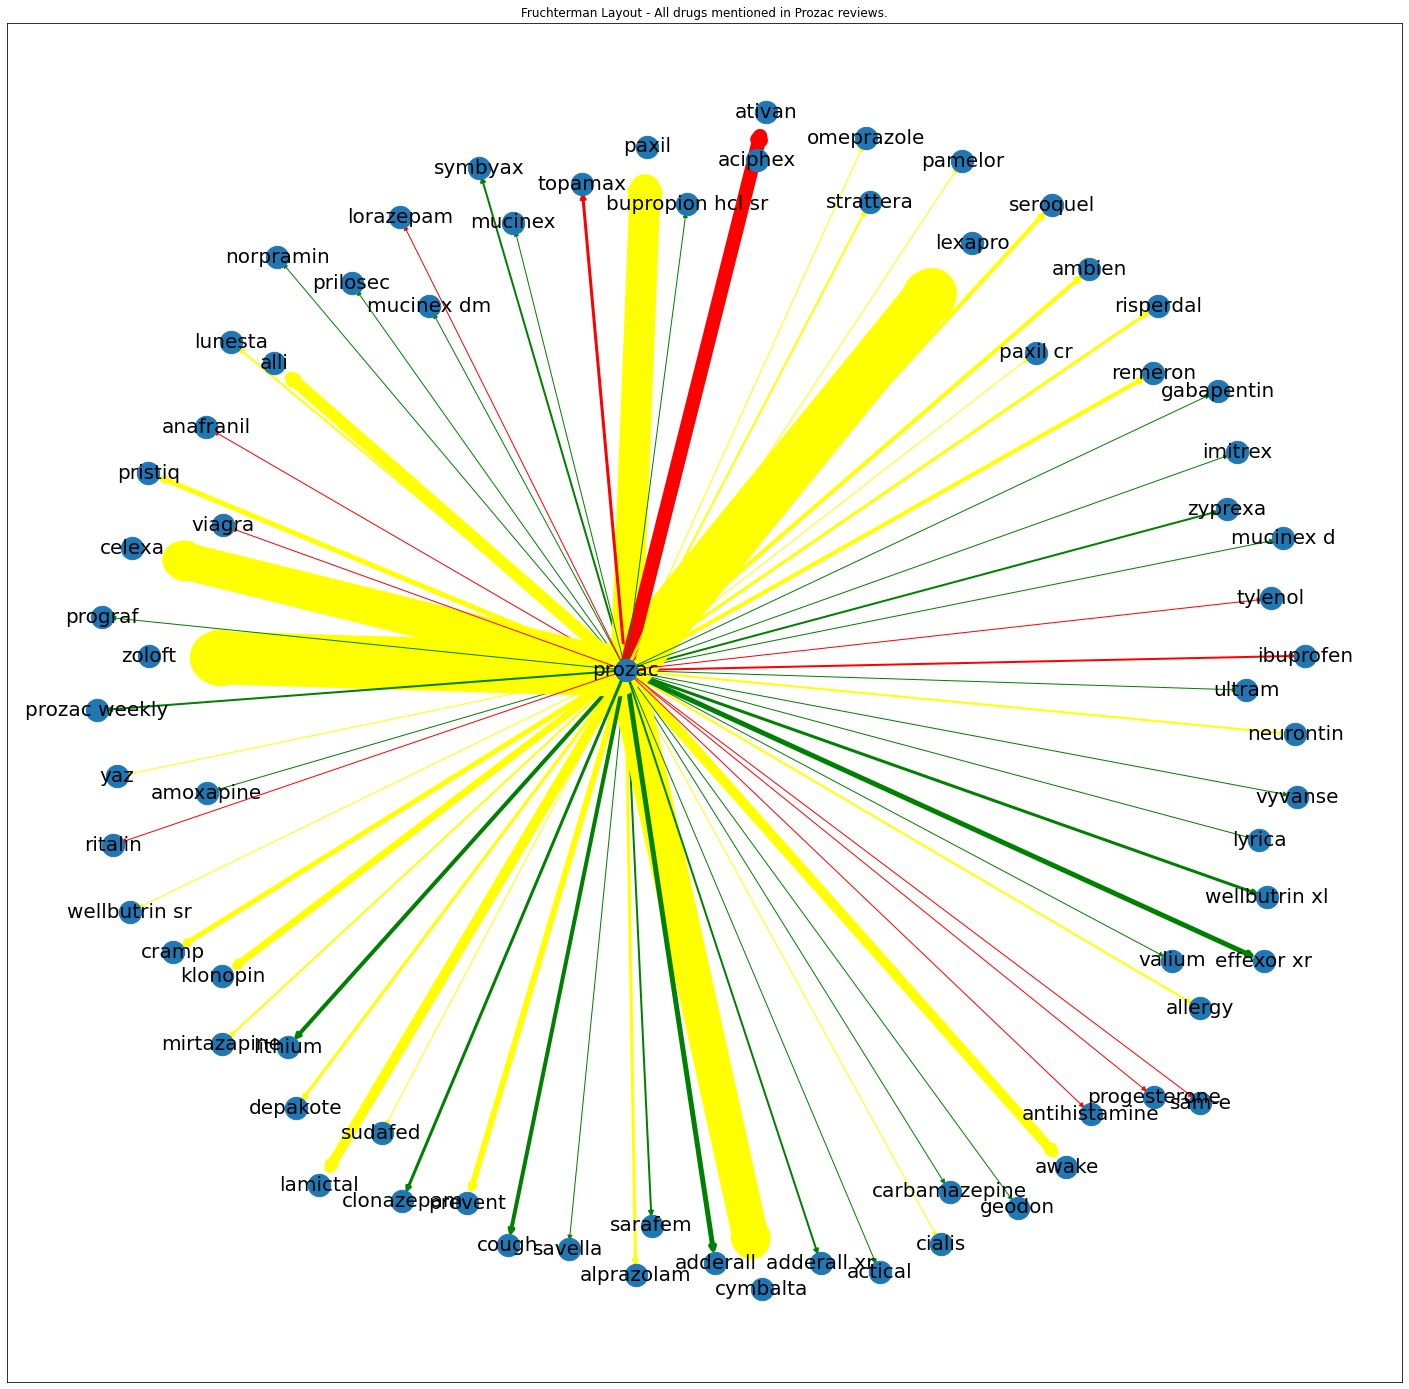

In [216]:
#snapshot for Prozac, look at other drugs mentioned in reviews and edge widths and colors.
G4 = nx.DiGraph()
edgeListDrugs2 = []
nodesListDrugs2 =[]
avoid_noise = ['iron','ne','d','take action','cla','nac','soma','orap','ella','slow fe','depen','essentia','motion sickness',
              'apri','onfi','emend','sleep aid','motion sickness','fe c']
drugListFilter = [i for i in drugs if i not in avoid_noise]
for drug in ['prozac']:
    rows = webmd[webmd['Drug'] == drug]

    
    for drug2 in drugListFilter:
        drug2rows = rows[rows['Reviews'].str.contains(drug2)]#rows of prozac reviews with second drug in review
        count = len(drug2rows)
        if count>0 and drug2 != drug:
            #drug2Rows = prozacRows[prozacRows['Reviews'].str.contains(drug2)]
            avgSatisfaction = sum(drug2rows['Satisfaction'].tolist())/count
            if avgSatisfaction>=3.5:
                drugSatisfactionColor='green'
            elif avgSatisfaction>=2:
                drugSatisfactionColor='yellow'
            else:
                drugSatisfactionColor='red'
                
            nodesListDrugs2 += [drug,drug2]
            G4.add_edge(drug, drug2,weight=count, color=drugSatisfactionColor)
            edgeListDrugs2+=[(drug, drug2)]

            
nodesListDrugs2 = set(nodesListDrugs2)
G4.add_nodes_from(nodesListDrugs2)

plt.figure(figsize = (25, 25))
plt.title("Fruchterman Layout - All drugs mentioned in Prozac reviews.", loc='center')
pos = nx.fruchterman_reingold_layout(G4) 
#nx.draw_networkx(G3,pos, node_size = 1000, font_size = 15, node_color = node_type_color_spec)
nx.draw_networkx_nodes(G4,pos, node_size=500)
nx.draw_networkx_labels(G4,pos, font_size = 20)
for edge in G4.edges(data=True):
    nx.draw_networkx_edges(G4, pos, edgelist=[edge], width=edge[2]['weight'], edge_color=edge[2]['color'])
plt.savefig('Prozac_drug_network_colored.jpg', dpi=100)
plt.show()